In [1]:
import pandas as pd
import numpy as np
import unidecode
import joblib

In [2]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

Objectif du notebook : 

Tester la performance des algos de régression sur une base à laquelle sont ajoutées des infos relatives aux DPE (Diagnostics de Performance Energétique) : année de construction d'immeuble ou maison, consommation énergétique, etc.

## Traitement base initiale

In [10]:
df = pd.read_csv('./databases/inter/03C - dvf_merged_2020.csv')
df.shape

C:\Users\olivier\anaconda\envs\py39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (8,18,20,22,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(501679, 86)

In [12]:
df = df.drop_duplicates(subset = ['Date mutation', 'Valeur fonciere', 'Adresse'])
df.shape

(485013, 86)

In [13]:
# Calcul de la date de référence : date max du dataframe
df['Date mutation'] = pd.to_datetime(df['Date mutation'], format="%d/%m/%Y")
df['date_ref'] = pd.to_datetime(df['Date mutation'].max(), format="%d/%m/%Y")
df.head()

,Unnamed: 0,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,Code commune INSEE,Ville,Adresse,Prix m2,Paris,dep_name,region_name,Mer,Commune_Lat,Commune_Lon,lon,lat,Code postal 5 chiffres,code_iris_clean,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Etab hospi,Gare,Gare nationale,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport,loyer,Population totale,SNHMO18,SNHMFO18,dep,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud,date_ref
0,0,1,2020-01-09,Vente,72000.0,5367.0,NaN,NaN,B107,LORETTE,1270.0,COLIGNY,1,108,NaN,AH,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,35.0,2.0,S,NaN,381.0,1108,1270 COLIGNY,5367 LORETTE 1270 COLIGNY,2057.142857,0,Ain,Auvergne-Rhône-Alpes,0,46.386664,5.330823,5.351500,46.380469,1270.0,11080000.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
1,1,1,2020-01-06,Vente,180300.0,31.0,NaN,RUE,0970,COMTE DE LA TEYSSONNIERE,1000.0,BOURG-EN-BRESSE,1,53,NaN,AI,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,75.0,4.0,S,NaN,525.0,1053,1000 BOURG EN BRESSE,31 RUE COMTE DE LA TEYSSONNIERE 1000 BOURG EN ...,2404.000000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.208966,46.197026,1000.0,10530203.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
2,2,1,2020-01-06,Vente,54800.0,6.0,NaN,AV,0770,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,1,53,NaN,BK,197,NaN,211,31.68,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,NaN,32.0,1.0,NaN,NaN,0.0,1053,1000 BOURG EN BRESSE,6 AV DU CHAMP DE FOIRE 1000 BOURG EN BRESSE,1712.500000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.229923,46.206965,1000.0,10530101.0,3.0,0.0,0.0,15.0,9.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,69.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
3,3,1,2020-01-13,Vente,97000.0,16.0,NaN,RUE,1770,DES GRAVES,1000.0,BOURG-EN-BRESSE,1,53,NaN,AZ,476,NaN,8,78.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,NaN,92.0,3.0,NaN,NaN,0.0,1053,1000 BOURG EN BRESSE,16 RUE DES GRAVES 1000 BOURG EN BRESSE,1054.347826,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.232291,46.199495,1000.0,10530302.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0,4.0,NaN,NaN,11.531505,10.275121,1.0,42.0,267.37,E,7.22,B,0.0,2020-12-31
4,4,1,2020-01-09,Vente,215000.0,2.0,NaN,IMP,0140,DU COLOMBIER,1250.0,TOSSIAT,1,422,NaN,D,1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,93.0,4.0,S,NaN,790.0,1422,1250 TOSSIAT,2 IMP DU COLOMBIER 1250 TOSSIAT,2311.827957,0,Ain,Auvergne-Rhône-Alpes,0,46.138479,5.304001,5.311045,46.141154,1250.0,14220000.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31


In [14]:
# Calcul de l'anciennete de la vente basée sur la date max contenue dans le modèle
import math
df['anciennete_vente'] = ((df['date_ref'] - df['Date mutation']) / np.timedelta64 (1, 'M'))
df['anciennete_vente'] = df['anciennete_vente'].apply(lambda x: math.floor(x))
df.head()

,Unnamed: 0,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,Code commune INSEE,Ville,Adresse,Prix m2,Paris,dep_name,region_name,Mer,Commune_Lat,Commune_Lon,lon,lat,Code postal 5 chiffres,code_iris_clean,Alimentation,Aéroport,Baignade,Banques,Boulangerie,Camping,Cinéma,Collège ou lycée,Crèche,Ecole mat et primaire,Ecole sup,Etab hospi,Gare,Gare nationale,Hotels,Info touristique,Parcours sportif/santé,Pharmacie,Police ou gendarmerie,Port plaisance,Restaurants,Resto U,Résidence U,Salle multisport,loyer,Population totale,SNHMO18,SNHMFO18,dep,anciennete,consommation_energie,classe_consommation_energie,estimation_ges,classe_estimation_ges,surface_baies_orientees_sud,date_ref,anciennete_vente
0,0,1,2020-01-09,Vente,72000.0,5367.0,NaN,NaN,B107,LORETTE,1270.0,COLIGNY,1,108,NaN,AH,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,35.0,2.0,S,NaN,381.0,1108,1270 COLIGNY,5367 LORETTE 1270 COLIGNY,2057.142857,0,Ain,Auvergne-Rhône-Alpes,0,46.386664,5.330823,5.351500,46.380469,1270.0,11080000.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11
1,1,1,2020-01-06,Vente,180300.0,31.0,NaN,RUE,0970,COMTE DE LA TEYSSONNIERE,1000.0,BOURG-EN-BRESSE,1,53,NaN,AI,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,75.0,4.0,S,NaN,525.0,1053,1000 BOURG EN BRESSE,31 RUE COMTE DE LA TEYSSONNIERE 1000 BOURG EN ...,2404.000000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.208966,46.197026,1000.0,10530203.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11
2,2,1,2020-01-06,Vente,54800.0,6.0,NaN,AV,0770,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,1,53,NaN,BK,197,NaN,211,31.68,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,NaN,32.0,1.0,NaN,NaN,0.0,1053,1000 BOURG EN BRESSE,6 AV DU CHAMP DE FOIRE 1000 BOURG EN BRESSE,1712.500000,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.229923,46.206965,1000.0,10530101.0,3.0,0.0,0.0,15.0,9.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,69.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11
3,3,1,2020-01-13,Vente,97000.0,16.0,NaN,RUE,1770,DES GRAVES,1000.0,BOURG-EN-BRESSE,1,53,NaN,AZ,476,NaN,8,78.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,NaN,92.0,3.0,NaN,NaN,0.0,1053,1000 BOURG EN BRESSE,16 RUE DES GRAVES 1000 BOURG EN BRESSE,1054.347826,0,Ain,Auvergne-Rhône-Alpes,0,46.205152,5.246021,5.232291,46.199495,1000.0,10530302.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0,4.0,NaN,NaN,11.531505,10.275121,1.0,42.0,267.37,E,7.22,B,0.0,2020-12-31,11
4,4,1,2020-01-09,Vente,215000.0,2.0,NaN,IMP,0140,DU COLOMBIER,1250.0,TOSSIAT,1,422,NaN,D,1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,93.0,4.0,S,NaN,790.0,1422,1250 TOSSIAT,2 IMP DU COLOMBIER 1250 TOSSIAT,2311.827957,0,Ain,Auvergne-Rhône-Alpes,0,46.138479,5.304001,5.311045,46.141154,1250.0,14220000.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,NaN,NaN,11.531505,10.275121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31,11


In [15]:
# Suppression des lignes avec coordonnées GPS KO (hors France métropolitaine)
print(df.shape)
df = df.drop(df[(df['lon'] < -6) | (df['lon'] > 9) | (df['lat'] < 42) | (df['lat'] > 52)].index)
print(df.shape)


(485013, 88)
(484982, 88)


In [16]:
# Calcul de l'année de la vente (en cas de fusion des bases DVF)
df['year'] = df['Date mutation'].dt.year
df.groupby('year')['year'].count()

year
2020    484982
Name: year, dtype: int64

In [17]:
# On conserve ce qu'il y a après 2020
df = df[df['year'] >= 2020]
df.shape

(484982, 89)

In [18]:
# Réévaluation a posteriori des prix (+3% / an)
# df['Prix m2 init'] = df['Prix m2']
# df['Prix m2'] = df.apply(lambda x: x['Prix m2'] * (1 + (x['anciennete_vente'] * 3 / 100 / 12)), axis = 1)

# df['Valeur fonciere init'] = df['Valeur fonciere']
# df['Valeur fonciere'] = df['Prix m2'] * df['Surface reelle bati']
# df.head()

In [19]:
df.columns

Index(['Unnamed: 0', 'No disposition', 'Date mutation', 'Nature mutation',
       'Valeur fonciere', 'No voie', 'B/T/Q', 'Type de voie', 'Code voie',
       'Voie', 'Code postal', 'Commune', 'Code departement', 'Code commune',
       'Prefixe de section', 'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'Code commune INSEE',
       'Ville', 'Adresse', 'Prix m2', 'Paris', 'dep_name', 'region_name',
       'Mer', 'Commune_Lat', 'Commune_Lon', 'lon', 'lat',
       'Code postal 5 chiffres', 'code_iris_clean', 'Alimentation', 'Aéroport',
       'Baignade', 'Banques', 'Boulan

## Feature Engineering

In [20]:
# Calcul du prix moyen au m² par commune, type local et nb pièces
df_prix_commune = df.groupby(['Code postal', 'Commune', 'Type local'])['Prix m2'].median()
df = df.merge(df_prix_commune, how = "left", on = ['Code postal', 'Commune', 'Type local']).rename(columns = {
        'Prix m2_x': 'Prix m2', 
        'Prix m2_y': 'prix m2 commune'})

# Calcul du prix moyen au m² par proximité GPS et type
df['lon_2'] = df['lon'].apply(lambda x: round(x, 2))     # On arrondit la longitude à 2 décimales afin de regrouper les biens par carré de 700m x 700m environ
df['lat_2'] = df['lat'].apply(lambda x: round(x, 2))     # Pareil pour latitude

df_prix_gps = df.groupby(['lon_2', 'lat_2', 'Type local'])['Prix m2'].median()
df = df.merge(df_prix_gps, how = "left", on = ['lon_2', 'lat_2', 'Type local']).rename(columns = {
        'Prix m2_x': 'Prix m2', 
        'Prix m2_y': 'prix m2 gps'})

In [21]:
# Export des prix / m²
df_prix_commune.to_csv('models/prix_m2_commune.csv')
df_prix_gps.to_csv('models/prix_m2_gps.csv')

In [22]:
df_other_feat = df[['Code postal', 'Commune', 'Type local', 'loyer', 'Population totale', 'SNHMO18', 'SNHMFO18']]
df_other_feat = df_other_feat.dropna().drop_duplicates()
df_other_feat['Code postal'] = df_other_feat['Code postal'].astype(int)
df_other_feat.to_csv('models/loy_rev_pop.csv')

## Choix des features à conserver pour le modèle final

In [23]:
# Conservation des features utiles
#df = df[['Valeur fonciere', 'Surface terrain', 'Surface reelle bati', 'Type local', 'Nombre pieces principales', 
#         'Paris', 'Mer', 'loyer', 'DISP_Q318', 'DISP_GI18', 'mois', 'SNHMO18', 'SNHMFO18', 'Population totale', 'anciennete', 
#         'consommation_energie', 'estimation_ges', 'surface_baies_orientees_sud', 'prix m2 commune', 'prix m2 gps']]
#df.columns

In [24]:
df.columns

Index(['Unnamed: 0', 'No disposition', 'Date mutation', 'Nature mutation',
       'Valeur fonciere', 'No voie', 'B/T/Q', 'Type de voie', 'Code voie',
       'Voie', 'Code postal', 'Commune', 'Code departement', 'Code commune',
       'Prefixe de section', 'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'Code commune INSEE',
       'Ville', 'Adresse', 'Prix m2', 'Paris', 'dep_name', 'region_name',
       'Mer', 'Commune_Lat', 'Commune_Lon', 'lon', 'lat',
       'Code postal 5 chiffres', 'code_iris_clean', 'Alimentation', 'Aéroport',
       'Baignade', 'Banques', 'Boulan

In [25]:
# Choix des features à conserver

bpe_use = 0           # On décide de ne pas conserver la BPE car dépend des codes IRIS qui ne sont plus dispos
dpe_use = 1           # On décide de ne pas conserver la DPE car on ne connaît pas le diagnostic souvent
loyer_use = 1
revenus_use = 1
popu_use = 1

dvf = ['Valeur fonciere', 'Surface terrain', 'Surface reelle bati', 'Type local', 'Nombre pieces principales', 
         'Paris', 'Mer', 'prix m2 commune', 'prix m2 gps']

bpe = ['Alimentation', 'Aéroport', 'Baignade', 'Banques', 'Boulangerie', 'Camping', 'Cinéma', 'Collège ou lycée', 
       'Crèche', 'Ecole mat et primaire', 'Ecole sup', 'Etab hospi', 'Gare', 'Gare nationale', 'Hotels', 'Info touristique',
       'Parcours sportif/santé', 'Pharmacie', 'Police ou gendarmerie', 'Port plaisance', 'Restaurants', 'Resto U', 
       'Résidence U', 'Salle multisport']

loyer = ['loyer']

dpe = ['anciennete', 'consommation_energie', 'estimation_ges']  # On ne conserve pas surface exposée plein sud car souvent pas dispo dans annonces

revenus = ['SNHMO18', 'SNHMFO18']

popu = ['Population totale']



# On conserve forcément les features correspondant à la base dvf
features_kept = dvf

# En fonction des choix, on ajoute ou non les features à conserver à la liste "features_kept"

if bpe_use == 1:
    features_kept.extend(bpe)
if dpe_use == 1:
    features_kept.extend(dpe)
if loyer_use == 1:
    features_kept.extend(loyer)
if revenus_use == 1:
    features_kept.extend(revenus)
if popu_use == 1:
    features_kept.extend(popu)

In [26]:
# Conservation des features utiles
df = df[features_kept]
df.columns

Index(['Valeur fonciere', 'Surface terrain', 'Surface reelle bati',
       'Type local', 'Nombre pieces principales', 'Paris', 'Mer',
       'prix m2 commune', 'prix m2 gps', 'anciennete', 'consommation_energie',
       'estimation_ges', 'loyer', 'SNHMO18', 'SNHMFO18', 'Population totale'],
      dtype='object')

In [27]:
# Suppression des valeurs NA en fonction des features conservées plus haut
print(df.isna().sum())
print('\n')
print('Taille du dataframe avant suppression des NA :', df.shape)

Valeur fonciere                   0
Surface terrain                   0
Surface reelle bati               0
Type local                        0
Nombre pieces principales         0
Paris                             0
Mer                               0
prix m2 commune                  14
prix m2 gps                   13713
anciennete                   244195
consommation_energie         244195
estimation_ges               244195
loyer                         32078
SNHMO18                           0
SNHMFO18                          0
Population totale             32078
dtype: int64


Taille du dataframe avant suppression des NA : (484982, 16)


In [28]:
df = df.dropna()
print('Taille du dataframe après suppression des NA :', df.shape)

Taille du dataframe après suppression des NA : (223240, 16)


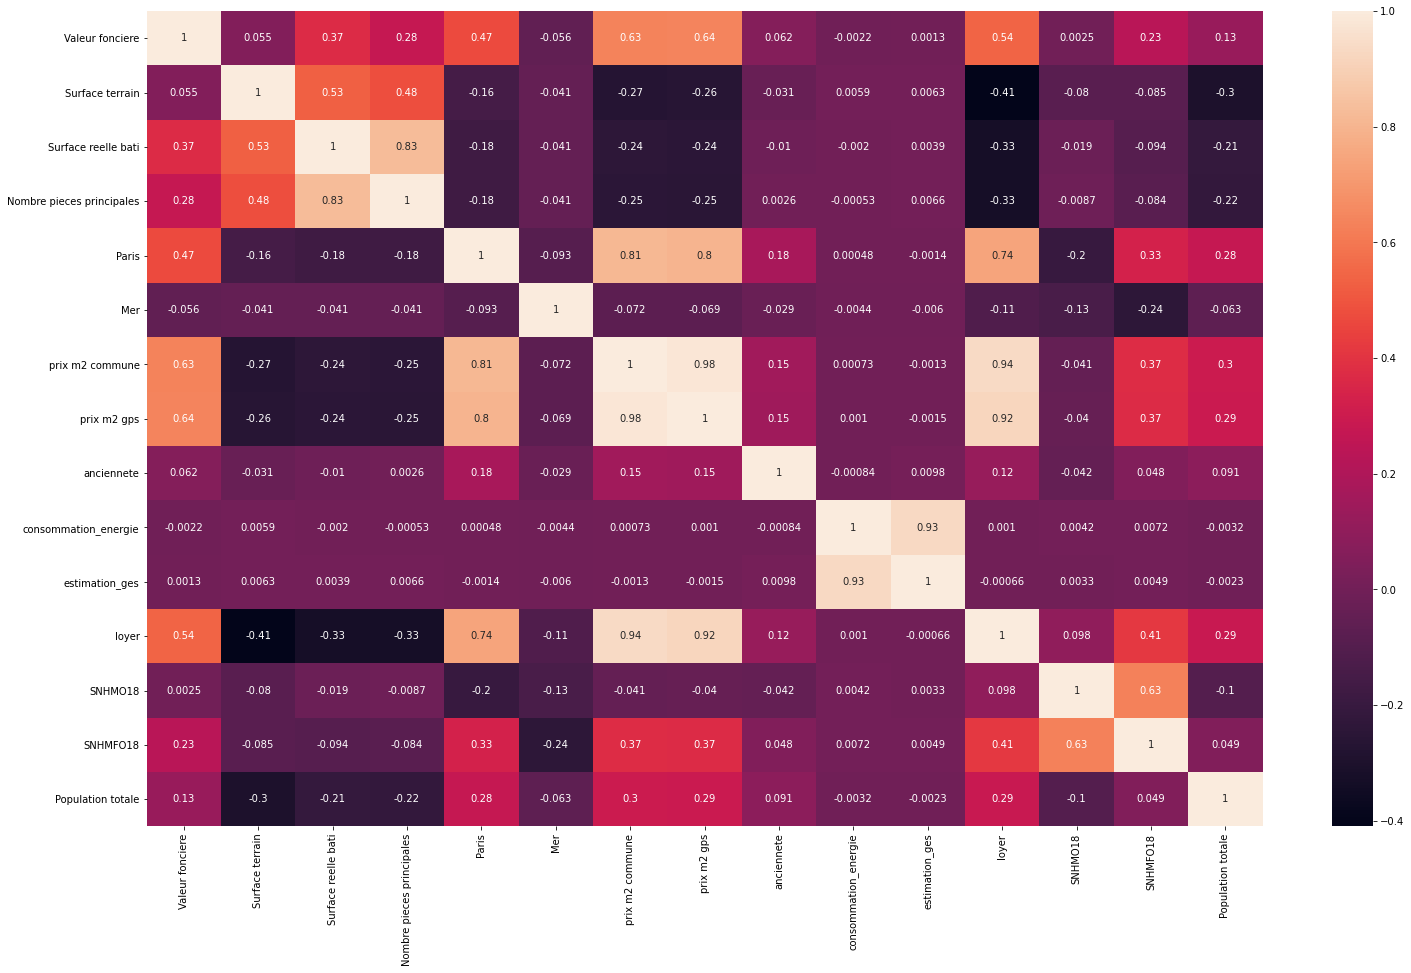

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affiche la heatmap avec les valeurs
plt.figure(figsize=(25, 15))
matrice_correlation = df.corr()
sns.heatmap(matrice_correlation, annot = True);

In [31]:
df.to_csv('databases/DVF_final_2020.csv')

## Algos de régression

On applique une régression sur l'ensemble de la base puis on réalise 3 modèles complémentaires en séparant les modèles ainsi : 
- Appartements Province
- Appartements Paris
- Maisons Province

In [70]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [71]:
df['Type local'] = df.apply(lambda x: 1 if x['Type local'] == "Maison" else 0, axis = 1)
df.head()

,Valeur fonciere,Surface terrain,Surface reelle bati,Type local,Nombre pieces principales,Paris,Mer,prix m2 commune,prix m2 commune,prix m2 commune,prix m2 gps,prix m2 gps,prix m2 gps,anciennete,consommation_energie,estimation_ges,loyer,SNHMO18,SNHMFO18,Population totale
32083,91000.0,444.0,78.0,1,4.0,0,0,1234.649123,1234.649123,1187.500000,1083.333333,1083.333333,1083.333333,24.0,361.64,20.86,5.976415,10.984865,9.693811,623.0
32085,78000.0,0.0,40.0,0,2.0,0,0,1387.096774,1387.096774,1314.285714,1526.315789,1526.315789,1526.315789,12.0,239.27,11.74,10.333854,10.984865,9.693811,12768.0
32087,52000.0,0.0,45.0,0,2.0,0,0,1547.619048,1547.619048,1502.551020,1609.195402,1609.195402,1609.195402,74.0,140.00,32.00,10.246045,10.984865,9.693811,63124.0
32089,67500.0,0.0,30.0,0,2.0,0,0,1547.619048,1547.619048,1502.551020,1745.333333,1745.333333,1745.333333,81.0,0.00,0.00,10.246045,10.984865,9.693811,63124.0
32090,112000.0,505.0,84.0,1,4.0,0,0,2111.111111,2111.111111,1877.976190,1755.201300,1755.201300,1755.201300,43.0,287.44,15.54,8.893778,10.984865,9.693811,4760.0


In [72]:
target = df['Valeur fonciere']
print(target.median())

181700.0


In [73]:
# Test 1 : Appartements hors Paris
df_1 = df[(df['Type local'] == 0) & (df['Paris'] == 0)]
target_1 = df_1['Valeur fonciere']
df_1 = df_1.drop(columns = {'Valeur fonciere'})
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, target_1, test_size = 0.2, random_state = 1234)

# Test 2 : Appartements Paris
df_2 = df[(df['Type local'] == 0) & (df['Paris'] == 1)]
target_2 = df_2['Valeur fonciere']
df_2 = df_2.drop(columns = {'Valeur fonciere'})
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2, target_2, test_size = 0.2, random_state = 1234)

# Test 3 : Maisons hors Paris
df_3 = df[(df['Type local'] == 1) & (df['Paris'] == 0)]
target_3 = df_3['Valeur fonciere']
df_3 = df_3.drop(columns = {'Valeur fonciere'})
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_3, target_3, test_size = 0.2, random_state = 1234)

In [74]:
# Affichage des prix moyens des biens
print(target_1.median())
print(target_2.median())
print(target_3.median())

155000.0
465000.0
205000.0


In [75]:
"""# Alternative : on prend les valeurs de Juin 2021 comme Test et les autres comme Train

df_train = df[df['anciennete_vente'] >= 1]
df_test = df[df['anciennete_vente'] == 0]

X_train = df_train.drop(columns = {'Valeur fonciere'})
y_train = df_train['Valeur fonciere']
X_test = df_test.drop(columns = {'Valeur fonciere'})
y_test = df_test['Valeur fonciere']"""

"# Alternative : on prend les valeurs de Juin 2021 comme Test et les autres comme Train\n\ndf_train = df[df['anciennete_vente'] >= 1]\ndf_test = df[df['anciennete_vente'] == 0]\n\nX_train = df_train.drop(columns = {'Valeur fonciere'})\ny_train = df_train['Valeur fonciere']\nX_test = df_test.drop(columns = {'Valeur fonciere'})\ny_test = df_test['Valeur fonciere']"

In [76]:
df = df.drop(columns = {'Valeur fonciere'})
df.shape

(223252, 19)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, random_state = 1234)

## Modèle global (tous biens confondus)

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
# Fonction d'entraînement de modèle Random Forest

def random_forest_model(X_train, X_test, y_train, y_test):
    print('X_train.shape: ', X_train.shape)
    print('X_test.shape: ', X_test.shape)
    print('y_train.shape: ', y_train.shape)
    print('y_test.shape: ', y_test.shape)
    
    regr = RandomForestRegressor(n_estimators = 50, max_depth = 500, min_samples_leaf = 5, random_state = 123)
    regr.fit(X_train, y_train)
    
    y_pred_train = regr.predict(X_train) 
    y_pred_test = regr.predict(X_test)
    
    score_train = regr.score(X_train, y_train)
    score_test = regr.score(X_test, y_test)
    rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
    rmse_test = mean_squared_error(y_pred_test, y_test, squared=False)
    mae_train = mean_absolute_error(y_pred_train, y_train)
    mae_test = mean_absolute_error(y_pred_test, y_test)
    
    results = {'score_train': score_train, 'score_test': score_test,
              'rmse_train': rmse_train, 'rmse_test': rmse_test,
              'mae_train': mae_train, 'mae_test': mae_test}

    print("score train:", score_train)
    print("score test:", score_test)

    print("rmse train : ", rmse_train)
    print('rmse test :', rmse_test)

    print("mae train : ", mae_train)
    print('mae test :', mae_test)
    
    return regr, results

In [80]:
column_list = df.columns.values

In [81]:
# Fonction de réduction de dimension de type lasso

from sklearn.linear_model import Lasso

def reduc_dim_lasso(X_train, X_test, y_train, y_test):
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso_r = Lasso(alpha = 1)
    lasso_r.fit(X_train, y_train)

    sel = SelectFromModel(estimator = lasso_r, threshold = 1e-10)
    sel.fit(X_train, y_train)

    mask = sel.get_support()
    plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
    plt.xlabel('Axe des features');
    plt.show();

    # Afficher un graphique représentant la valeur estimée du coefficient pour chaque variable de data
    plt.figure(figsize = (20, 10))

    lasso_coef = lasso_r.coef_ 
    plt.bar(range(len(df.columns)), lasso_coef) 
    plt.xticks(range(len(df.columns)), column_list, rotation=70);

X_train.shape:  (178601, 19)
X_test.shape:  (44651, 19)
y_train.shape:  (178601,)
y_test.shape:  (44651,)
score train: 0.9532896207670409
score test: 0.9066705520249291
rmse train :  40430.62045541346
rmse test : 58062.461525826315
mae train :  22868.867015385105
mae test : 34464.41078322835


Objective did not converge. You might want to increase the number of iterations. Duality gap: 42787093143070.5, tolerance: 625016244792.6404
Objective did not converge. You might want to increase the number of iterations. Duality gap: 42787093143070.5, tolerance: 625016244792.6404


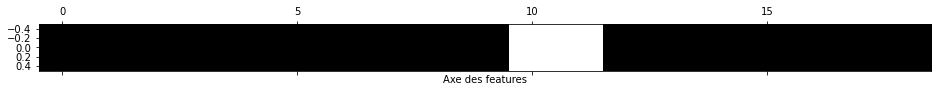

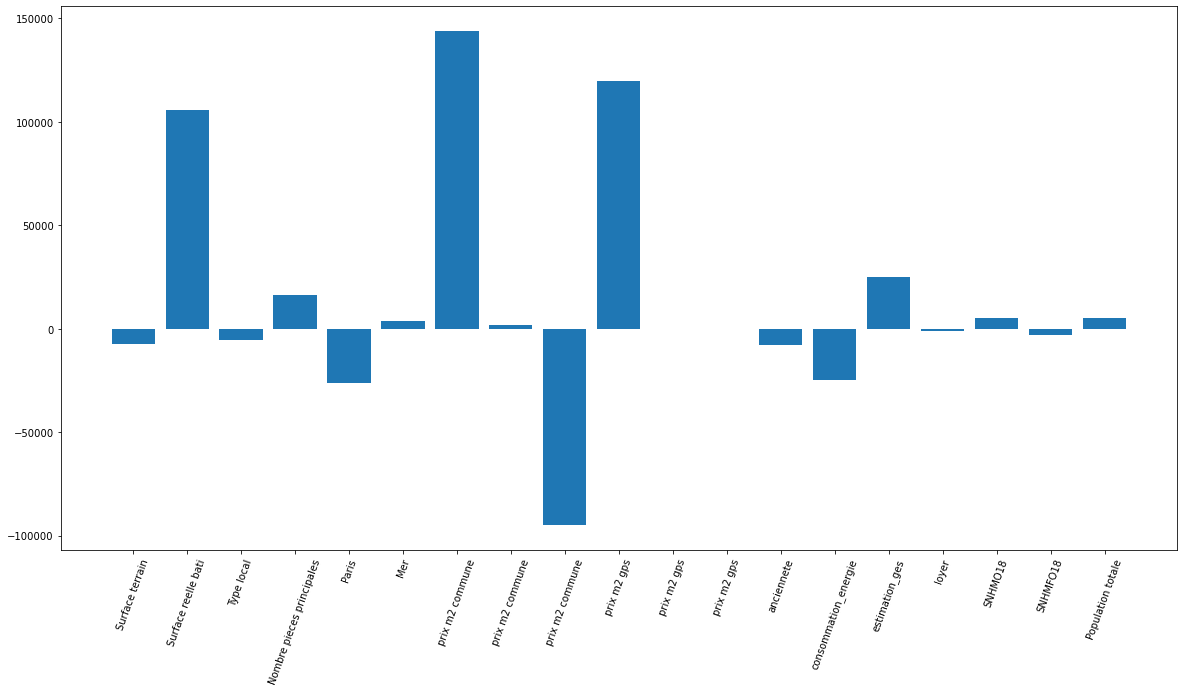

In [82]:
# Modèle global
rf_all, results_all = random_forest_model(X_train, X_test, y_train, y_test)
reduc_dim_lasso(X_train, X_test, y_train, y_test)

X_train.shape:  (93950, 19)
X_test.shape:  (23488, 19)
y_train.shape:  (93950,)
y_test.shape:  (23488,)
score train: 0.931978105924698
score test: 0.8630794479812148
rmse train :  35007.62788441969
rmse test : 49090.36712878055
mae train :  19985.310133632214
mae test : 29018.36857424517


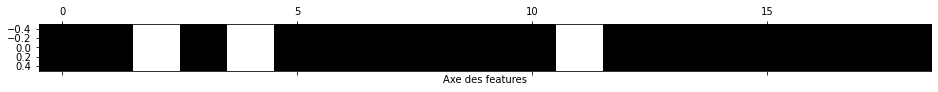

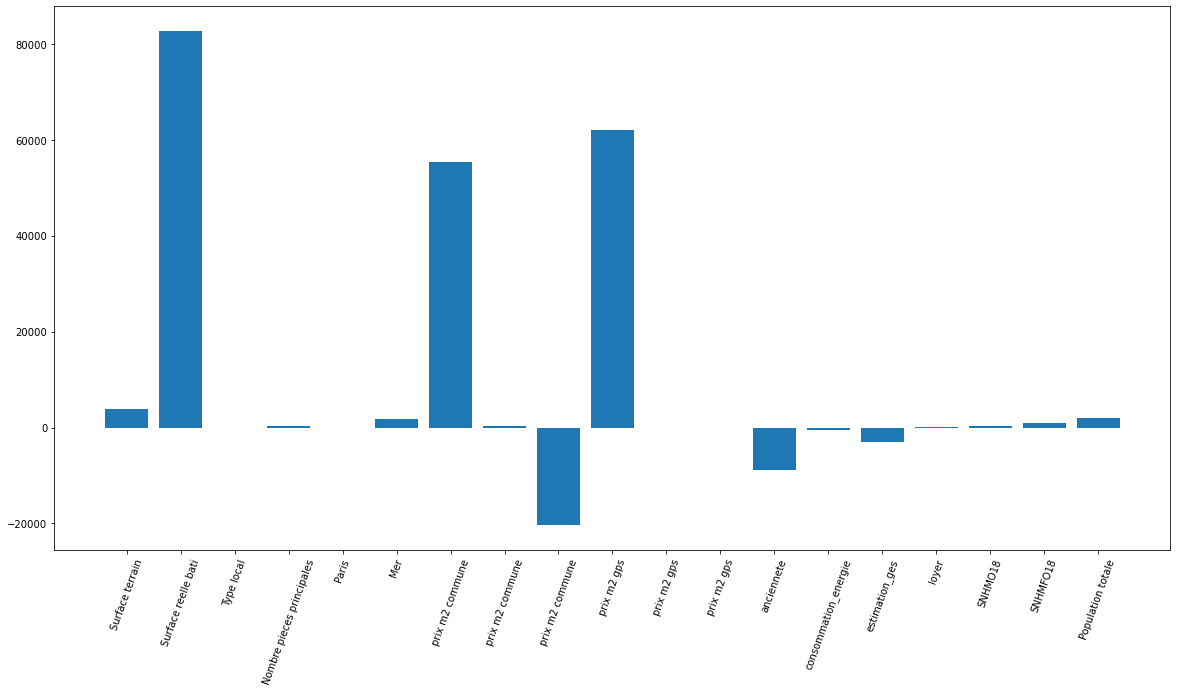

In [83]:
# Modèle 1 - Appartements hors Paris
rf_1, results_1 = random_forest_model(X_train_1, X_test_1, y_train_1, y_test_1)
reduc_dim_lasso(X_train_1, X_test_1, y_train_1, y_test_1)

X_train.shape:  (11524, 19)
X_test.shape:  (2882, 19)
y_train.shape:  (11524,)
y_test.shape:  (2882,)
score train: 0.9541417858044787
score test: 0.9126673731959816
rmse train :  77238.66964787798
rmse test : 111659.20758735642
mae train :  51707.52162306233
mae test : 74270.88389727841


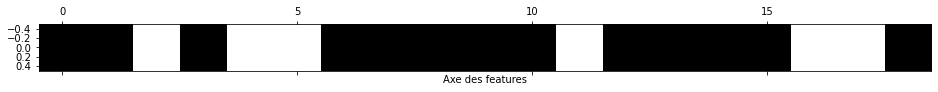

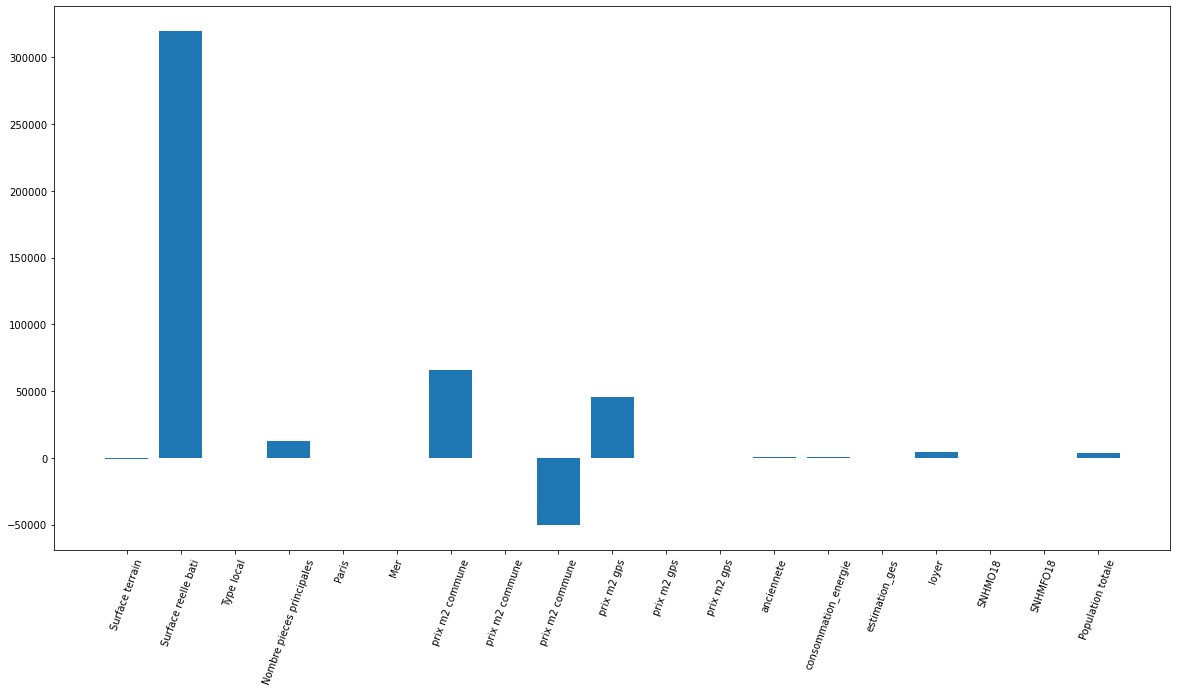

In [84]:
# Modèle 2 - Appartements Paris
rf_2, results_2 = random_forest_model(X_train_2, X_test_2, y_train_2, y_test_2)
reduc_dim_lasso(X_train_2, X_test_2, y_train_2, y_test_2)

X_train.shape:  (73119, 19)
X_test.shape:  (18280, 19)
y_train.shape:  (73119,)
y_test.shape:  (18280,)
score train: 0.9332175233947726
score test: 0.8465139823241491
rmse train :  37898.732135587605
rmse test : 57939.20520780432
mae train :  22131.796198203752
mae test : 34962.71875266913


Objective did not converge. You might want to increase the number of iterations. Duality gap: 35862406732908.44, tolerance: 157259570487.36743
Objective did not converge. You might want to increase the number of iterations. Duality gap: 35862406732908.44, tolerance: 157259570487.36743


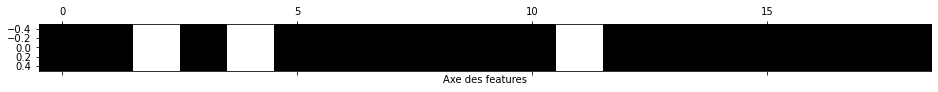

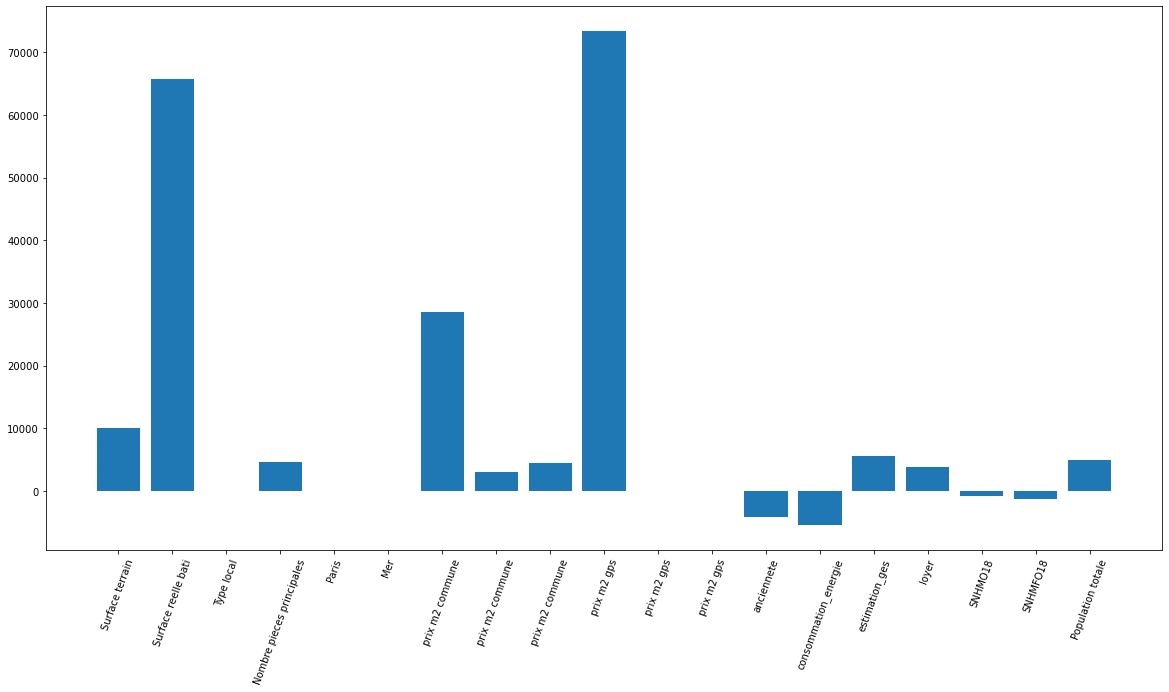

In [85]:
# Modèle 3 - Maisons Province
rf_3, results_3 = random_forest_model(X_train_3, X_test_3, y_train_3, y_test_3)
reduc_dim_lasso(X_train_3, X_test_3, y_train_3, y_test_3)

In [86]:
def print_results(model_name, results):
    print(model_name + " : ")
    print("Score Test: " + str(round(results['score_test'], 4)))
    print("MAE Test: " + str(round(results['mae_test'], 0)))
    print('\n')

print_results("Modèle global", results_all)
print_results("Modèle 1 - Appartements Province", results_1)
print_results("Modèle 2 - Appartements Paris", results_2)
print_results("Modèle 3 - Maisons Province", results_3)

Modèle global : 
Score Test: 0.9067
MAE Test: 34464.0


Modèle 1 - Appartements Province : 
Score Test: 0.8631
MAE Test: 29018.0


Modèle 2 - Appartements Paris : 
Score Test: 0.9127
MAE Test: 74271.0


Modèle 3 - Maisons Province : 
Score Test: 0.8465
MAE Test: 34963.0




In [38]:
# Sauvegarde des modèles
joblib.dump(rf_all, 'models/model_rf_all.pkl', compress = 3)
joblib.dump(rf_1, 'models/model_rf_1_appart_province.pkl', compress = 3)
joblib.dump(rf_2, 'models/model_rf_2_appart_paris.pkl', compress = 3)
joblib.dump(rf_3, 'models/model_rf_3_maison_province.pkl', compress = 3)

['models/model_rf_3_maison_province.pkl']

In [39]:
# Export de la liste des colonnes de X_train
feature_list = list(X_train.columns)

df_feat = pd.DataFrame({'feature_name': feature_list})
#df_feat = pd.DataFrame({'feature_name': feature_list}, index = [i for i in range (0, len(feature_list))])
df_feat.to_csv('models/features_list_for_model_A.csv')

In [40]:
### Archive Recherche Meilleurs Hyperparamètres

"""
{'max_depth': 500, 'min_samples_leaf': 5, 'n_estimators': 50}



rf = RandomForestRegressor(max_features='sqrt')  

param_grid = {  
           "n_estimators" : [20, 50, 100],  
           "max_depth" : [250, 500, 1000],  
           "min_samples_leaf" : [5, 15, 25]}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)  
CV_rf.fit(X_train, y_train)  
print(CV_rf.best_params_)"""

'\n{\'max_depth\': 500, \'min_samples_leaf\': 5, \'n_estimators\': 50}\n\n\n\nrf = RandomForestRegressor(max_features=\'sqrt\')  \n\nparam_grid = {  \n           "n_estimators" : [20, 50, 100],  \n           "max_depth" : [250, 500, 1000],  \n           "min_samples_leaf" : [5, 15, 25]}\n\nCV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)  \nCV_rf.fit(X_train, y_train)  \nprint(CV_rf.best_params_)'

## Interprétabilité du modèle

In [41]:
import shap

# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

def interp_model(model, X_test):
    explainerModel = shap.TreeExplainer(model)
    shap_values = shap.TreeExplainer(model).shap_values(X_test)
#    shap.summary_plot(shap_values, X_test, plot_type="bar")
    
    import matplotlib.pyplot as plt
    f = plt.figure()
    shap.summary_plot(shap_values, X_test)
    #f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)
    
    X_output = X_test.copy()
    X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

    # Randomly pick some observations
    random_picks = np.arange(1,330,50) # Every 50 rows
    S = X_output.iloc[random_picks]
    shap_values_Model = explainerModel.shap_values(S)
    
    return S, shap_values_Model

def plot_illustration(S, example, i):
    p = shap.force_plot(explainerModel.expected_value, example[i], S.iloc[[i]])
    return(p)

In [42]:
# S, examples = interp_model(rf_all, X_test)
# plot_illustration(S, examples, 0)

In [43]:
df.columns

Index(['Surface terrain', 'Surface reelle bati', 'Type local',
       'Nombre pieces principales', 'Paris', 'Mer', 'prix m2 commune',
       'prix m2 gps', 'anciennete', 'consommation_energie', 'estimation_ges',
       'loyer', 'SNHMO18', 'SNHMFO18', 'Population totale'],
      dtype='object')